In [2]:
from azure.storage.blob import BlobServiceClient
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import io  # Used to convert bytes to a file-like object


#set up storage
connection_string = 
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)




In [12]:
# Loop through all blobs and process JSON files
json_data = {}

blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".json"):
        # Get the blob content
        blob_client = container_client.get_blob_client(blob.name)
        blob_content = blob_client.download_blob().content_as_text()

        # Convert to JSON and add to the dictionary using the blob's name as the key
        json_data[blob.name] = json.loads(blob_content)  # Now storing JSON content as a dictionary

# Assigning specific JSON data to variables
category = json_data.get("v1.0-mini/category.json", [])
sensor = json_data.get("v1.0-mini/sensor.json", {})
surface_ann = json_data.get("v1.0-mini/surface_ann.json", {})
attribute = json_data.get("v1.0-mini/attribute.json", {})
log = json_data.get("v1.0-mini/log.json", {})
calibrated_sensor = json_data.get("v1.0-mini/calibrated_sensor.json", {})
sample_data = json_data.get("v1.0-mini/sample_data.json", {})
sample = json_data.get("v1.0-mini/sample.json", {})
ego_pose = json_data.get("v1.0-mini/ego_pose.json", {})
object_ann = json_data.get("v1.0-mini/object_ann.json", {})

### Plotting an Image

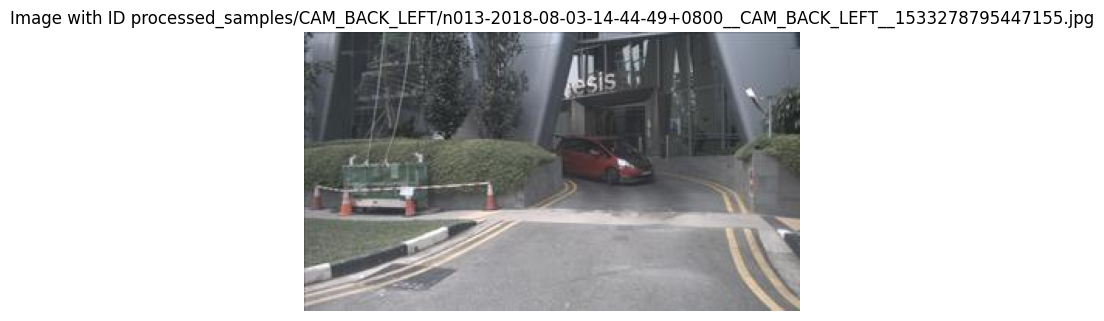

In [41]:
##### Plot plain image

# Directory where your JPEG files are located
def plot_image(image_id):
    # Get the BlobClient for the specific image
    blob_client = container_client.get_blob_client(image_id)

    # Download the blob's content as bytes
    blob_data = blob_client.download_blob().chunks()  # Read the entire blob content

    # Convert the blob data into a file-like object using io.BytesIO
    image_data = io.BytesIO(b"".join(blob_data))

    # Open the image using PIL.Image
    image = Image.open(image_data)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Image with ID {image_id}")
    plt.show()

plot_image("processed_samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg")

### Get Categories of Image

In [48]:
# Function to get the categories for a given image name
def get_categories(image_id):
    
    #checks the folder of the image, to find the json data even when it is not in "samples"
    parts = image_id.split("/", 1)  # Only split on the first occurrence
    # Check if the first part is 'samples'
    if parts[0] == "samples":
        # If it starts with 'samples', keep it as is
        image_id = image_id
    else:
        # If not, replace the first part with 'samples'
        image_id = "samples/" + parts[1]
    
    # Find the token in sample_data corresponding to the image_name
    image_token = None
    for item in sample_data:
        if item.get("filename") == image_id:
            image_token = item.get("token")
            break

    if not image_token:
        return f"Image name '{image_id}' not found."

    # Find the object annotations linked to the sample_data_token
    object_ann_tokens = [obj_ann for obj_ann in object_ann if obj_ann.get("sample_data_token") == image_token]

    if not object_ann_tokens:
        return f"No object annotations found for image name '{image_id}'."

    # Get the category names from the category_token
    category_names = []
    for obj_ann in object_ann_tokens:
        category_token = obj_ann.get("category_token")
        category_name = next((cat["name"] for cat in category if cat.get("token") == category_token), None)
        if category_name:
            category_names.append(category_name)

    return category_names if category_names else f"No categories found for image name '{image_id}'."

# Example: Get categories for a specific image name
image_id = "processed_samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg"  # Replace with your desired image name
categories = get_categories(image_id)
print("Categories for image", image_id, ":", categories)


Categories for image processed_samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg : ['movable_object.trafficcone', 'movable_object.trafficcone', 'human.pedestrian.adult', 'movable_object.trafficcone', 'movable_object.trafficcone', 'vehicle.car', 'movable_object.pushable_pullable', 'human.pedestrian.adult']


### Prepocessing

In [34]:
# Function to downscale and re-upload the image to a new path
def downscale_and_reupload(image_blob_name, downscale_factor):
    # Download the original image
    blob_client = container_client.get_blob_client(image_blob_name)
    blob_data = blob_client.download_blob().readall()

    # Open the image using Pillow
    image_data = io.BytesIO(blob_data)
    image = Image.open(image_data)

    # Downscale the image
    new_width = image.width // downscale_factor
    new_height = image.height // downscale_factor
    downscaled_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Save the downscaled image to a file-like object
    output_stream = io.BytesIO()
    downscaled_image.save(output_stream, format='JPEG')
    output_stream.seek(0)  # Reset the stream position to the beginning

    # Create a new blob name with the desired path
    new_blob_name = image_blob_name.replace("samples", "processed_samples")

    # Re-upload the downscaled image to the new path
    new_blob_client = container_client.get_blob_client(new_blob_name)
    new_blob_client.upload_blob(output_stream, overwrite=True)  # Overwrite if it exists

    return new_blob_name  # Return the name of the re-uploaded image

# Example image to process
image_blob_name = "samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg"

# Downscale the image and re-upload to a new path
downscaled_image_blob_name = downscale_and_reupload(image_blob_name, 5)

print(f"Downscaled image re-uploaded as: {downscaled_image_blob_name}")


Downscaled image re-uploaded as: processed_samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg


### Upload Files to Azure from local directory

In [30]:
# Function to upload a jpg file to Azure Blob Storage with "CAM_BACK/" prefix
def upload_jpg_to_blob(file_name, folder_path):
    # Full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Blob name with "CAM_BACK/" prefix
    blob_name = f"samples/CAM_BACK_RIGHT/{file_name}"

    # Create a BlobClient for the blob
    blob_client = container_client.get_blob_client(blob_name)
    
    # Read the file and upload it to Azure
    with open(file_path, 'rb') as file_data:  # Open in binary mode
        blob_client.upload_blob(file_data, overwrite=True)  # Overwrite if the blob exists

In [31]:
#upload images to azure

container_name = "publicdatacomplete"  # Your Azure Blob Storage container
container_client = blob_service_client.get_container_client(container_name)

# Directory containing the CAM_BACK folder with jpg files
base_directory = "/Volumes/SSD/NuImages/nuimages/nuimages-v1.0-all-samples/samples/"  # Local path to your directory

all_items = ['CAM_BACK_RIGHT','CAM_FRONT','CAM_FRONT_LEFT','CAM_FRONT_RIGHT']

for item in all_items: 
    if item == ".DS_Store":
        continue 
    else:
        folder_name = f"{item}/"
        # Full path to the folder
        path = os.path.join(base_directory, folder_name)
        # Get all jpg files in the CAM_BACK folder
        jpg_files = [f for f in os.listdir(path) if f.lower().endswith(".jpg")] 
        
        uploaded_count = 0   
        # Loop through all jpg files and upload them to Azure Blob Storage
        for file_name in jpg_files:
            upload_jpg_to_blob(file_name, path)  # Upload the jpg file
            uploaded_count += 1  # Increment the counter for successful uploads
            print(f"Uploaded: {file_name} to samples/{folder_name}")
            print(f"Uploaded {uploaded_count} out of {len(jpg_files)} JPG files in {folder_name}")

Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864936124954.jpg to samples/CAM_BACK_RIGHT/
Uploaded 1 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864956209162.jpg to samples/CAM_BACK_RIGHT/
Uploaded 2 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864966209634.jpg to samples/CAM_BACK_RIGHT/
Uploaded 3 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864976460082.jpg to samples/CAM_BACK_RIGHT/
Uploaded 4 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864986460475.jpg to samples/CAM_BACK_RIGHT/
Uploaded 5 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864996460961.jpg to samples/CAM_BACK_RIGHT/
Uploaded 6 out of 13341 JPG files in CAM_BACK_RIGHT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_RI

OSError: [Errno 6] Device not configured

In [16]:
#upload images to azure

container_name = "publicdatacomplete"  # Your Azure Blob Storage container
container_client = blob_service_client.get_container_client(container_name)




# Directory containing the CAM_BACK folder with jpg files
base_directory = "/Volumes/SSD/NuImages/nuimages/nuimages-v1.0-all-samples/samples/"  # Local path to your directory

# Folder name containing jpg files
folder_name = "CAM_BACK_LEFT/"

# Full path to the folder
cam_back_path = os.path.join(base_directory, folder_name)

# Get all jpg files in the CAM_BACK folder
jpg_files = [f for f in os.listdir(cam_back_path) if f.lower().endswith(".jpg")]


# Loop through all jpg files and upload them to Azure Blob Storage
for file_name in jpg_files:
    upload_jpg_to_blob(file_name, cam_back_path)
    print(f"Uploaded: {file_name} to samples/CAM_BACK_LEFT/")



Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864956197197.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864966197585.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864976197980.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864980031490.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864996198748.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514865006199149.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514865016199522.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514865026199901.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514865033283592.jpg to samples/CAM_BACK_LEFT/
Uploaded: n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514865036200298.

### Count Files in Azure Folder

In [17]:
#check number ob blobs in folder

container_name = "publicdatacomplete"  # Your Azure Blob Storage container
container_client = blob_service_client.get_container_client(container_name)

# Specify the folder prefix (e.g., "samples/")
folder_prefix = "samples/CAM_BACK_LEFT"

# List all blobs in the container
blobs = container_client.list_blobs(name_starts_with=folder_prefix)

# Count the blobs that start with the specified folder prefix
blob_count = sum(1 for _ in blobs)  # Generator comprehension to count blobs

print(f"Number of blobs in '{folder_prefix}': {blob_count}")


Number of blobs in 'samples/CAM_BACK_LEFT': 14882


### Delete files in Azure

In [13]:
### delete files in azure
# Specify the folder prefix (e.g., "samples/")
folder_prefix = "samples/"

# List all blobs in the folder
blobs = container_client.list_blobs(name_starts_with=folder_prefix)

# Delete each blob in the folder
for blob in blobs:
    blob_client = container_client.get_blob_client(blob.name)
    blob_client.delete_blob()
    print(f"Deleted blob: {blob.name}")

Deleted blob: samples/CAM_BACK/n003-2018-01-03-12-03-23+0800__CAM_BACK__1514952316316487.jpg
Deleted blob: samples/CAM_BACK/n003-2018-01-08-11-30-34+0800__CAM_BACK__1515382745757583.jpg
Deleted blob: samples/CAM_BACK/n003-2018-07-12-15-40-35+0800__CAM_BACK__1531383596387543.jpg
Deleted blob: samples/CAM_BACK/n005-2018-06-14-20-11-03+0800__CAM_BACK__1528979868187591.jpg
Deleted blob: samples/CAM_BACK/n008-2018-06-04-16-30-00-0400__CAM_BACK__1528144232887570.jpg
Deleted blob: samples/CAM_BACK/n009-2018-05-08-15-52-41-0400__CAM_BACK__1525809758643363.jpg
Deleted blob: samples/CAM_BACK/n010-2018-08-27-12-00-23+0800__CAM_BACK__1535342963787283.jpg
Deleted blob: samples/CAM_BACK/n013-2018-08-20-14-38-24+0800__CAM_BACK__1534747168787005.jpg
Deleted blob: samples/CAM_BACK/n013-2018-08-21-11-46-25+0800__CAM_BACK__1534823329537005.jpg
Deleted blob: samples/CAM_BACK/n013-2018-08-28-16-04-27+0800__CAM_BACK__1535443725287005.jpg
Deleted blob: samples/CAM_BACK/n013-2018-08-29-11-41-15+0800__CAM_BACK

In [29]:
all_items = os.listdir(base_directory)
all_items


['.DS_Store',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_BACK_RIGHT',
 'CAM_FRONT',
 'CAM_FRONT_LEFT',
 'CAM_FRONT_RIGHT']